# Project 2, Part 7, Executive summary

University of California, Berkeley

Master of Information and Data Science (MIDS) program

w205 - Fundamentals of Data Engineering

Student: Jack Galvin

Year: 2022

Semester: Spring

Section: 9


# Included Modules and Packages

Code cell containing your includes for modules and packages

In [37]:
import pandas as pd
import numpy as np
import math
import psycopg2
from fuzzywuzzy import fuzz
from fuzzywuzzy import process as fuzz_process
import matplotlib.pyplot as plt
%matplotlib inline

# Supporting code

Code cells containing any supporting code, such as connecting to the database, any functions, etc.  

Remember you can freely use any code from the labs. You do not need to cite code from the labs.

In [2]:
connection = psycopg2.connect(
    user = "postgres",
    password = "ucb",
    host = "postgres",
    port = "5432",
    database = "postgres"
)

In [3]:
cursor = connection.cursor()

In [4]:
# Function to run a select query and return rows in a pandas dataframe
# Pandas puts all numeric values from postgres to float
# If it will fit in an integer, change it to integer


def my_select_query_pandas(query, rollback_before_flag, rollback_after_flag):
    "function to run a select query and return rows in a pandas dataframe"
    
    if rollback_before_flag:
        connection.rollback()
    
    df = pd.read_sql_query(query, connection)
    
    if rollback_after_flag:
        connection.rollback()
    
    # fix the float columns that really should be integers
    
    for column in df:
    
        if df[column].dtype == "float64":

            fraction_flag = False

            for value in df[column].values:
                
                if not np.isnan(value):
                    if value - math.floor(value) != 0:
                        fraction_flag = True

            if not fraction_flag:
                df[column] = df[column].astype('Int64')
    
    return(df)

# 2.7.1 Executive summary

Write an executive summary.  

The summary should be the equivalent to 3/4 to 1 page using standard fonts, spacing, and margins. 

You may write about any aspect (or aspects).  Basically figure out what you think is the most import aspect (or aspects) that the executives would want to know.  

It could be related to the process itself. Such as how you were able to take a dataset, load it into staging tables, and get analytics very quickly, instead of a months long traditional waterfall process. 

It could be related to the preliminary analytics.  Any insights you gained.  Possible comparison to the analytics from project 1.  Do the delivery sales have different patterns or the same patterns as in store sales?  Is this a good way to grow sales? etc.

It could be related to both.

You are not required to write any queries nor create any data visualizations.  However, you may want to include some to enhance and add quality to your submission.  Submissions with these tend to be higher quality, although, not always.

You may use any number of code cells and/or markdown cells. 

You may alternate between code cells and markdown cells.  That is perfectly fine.  It is understood that before we present it, an editor would pull out the text, results of queries, and data visualizations.

# Motivation for the Following Analysis

From our last analysis, we showed that most customers lived within 15 miles of the closest store and proposed a delivery option to capture market share from customers who lived farther away. The below plot was presented with that analysis and is included again for convenience.

We aim to evaluate if solidifying a delivery option with Peak is a good business decision.

In [63]:
rollback_before_flag = True
rollback_after_flag = True

query = """

select s.city as store,
        cu.distance as distance,
        cu.first_name,
        cu.last_name,
        count(cu.customer_id) as total_customers
from stores as s
    join customers as cu
        on s.store_id = cu.closest_store_id
group by store, distance, cu.first_name, cu.last_name
order by distance

"""

agm_df = my_select_query_pandas(query, rollback_before_flag, rollback_after_flag)

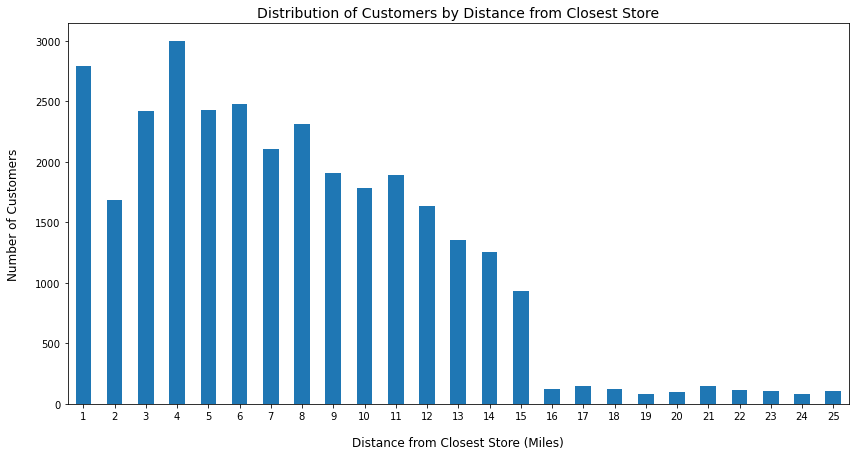

In [64]:
# Plot the results of the above query
fig, ax = plt.subplots()
agm_df.groupby("distance")["total_customers"].sum().plot(kind="bar", figsize=(14,7))

# Add titles and axes labels
plt.title("Distribution of Customers by Distance from Closest Store", fontsize=14)
ax.set_ylabel("Number of Customers", labelpad=15, fontsize=12)
ax.set_xlabel("Distance from Closest Store (Miles)", labelpad=15, fontsize=12)
plt.xticks(rotation=0);

# Visualize Distribution of Customer Addresses in the Berkeley Area

We confirm that the distribution of customer addresses near the Berkeley store is similar to the distribution of customer addresses across all stores. Consistent with the results we presented above, most customers in the Berkeley area live within 15 miles of the Berkeley store. 

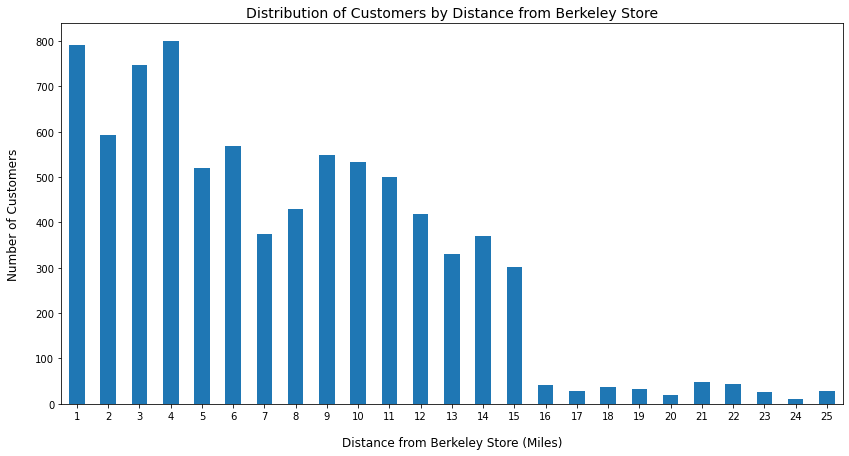

In [65]:
berk_df = agm_df[agm_df["store"] == "Berkeley"]

# Plot the results
fig, ax = plt.subplots()
berk_df.groupby("distance")["total_customers"].sum().plot(kind="bar", figsize=(14,7))

# Add titles and axes labels
plt.title("Distribution of Customers by Distance from Berkeley Store", fontsize=14)
ax.set_ylabel("Number of Customers", labelpad=15, fontsize=12)
ax.set_xlabel("Distance from Berkeley Store (Miles)", labelpad=15, fontsize=12)
plt.xticks(rotation=0);

# Investigate Who Signed Up with Peak

We investigate if the customers who live over 15 miles from the Berkeley store actually signed up for delivery with Peak. We use the fuzzy logic method to correct small inaccuracies in the customer data that Peak maintains. 

##### Build a data frame with the customers who match Peak data

In [52]:
# Find first names, last names, and streets that match

rollback_before_flag = True
rollback_after_flag = True

query = """

select *
from stage_1_peak_customers
where (first_name, last_name, street) in (
    select first_name, last_name, street
    from customers)
order by stage_id;

"""

df_1 = my_select_query_pandas(query, rollback_before_flag, rollback_after_flag)

##### Build a data frame with the customers who don't match Peak data

In [53]:
# Find first names, last names, and streets that don't match

rollback_before_flag = True
rollback_after_flag = True

query = """

select *
from stage_1_peak_customers
where (first_name, last_name, street) not in (
    select first_name, last_name, street
    from customers)
order by stage_id;

"""

df_2 = my_select_query_pandas(query, rollback_before_flag, rollback_after_flag)

# Concatenate first and last names and drop old columns
df_2["full_name"] = df_2["first_name"] + " " + df_2["last_name"]
df_2.drop(["first_name", "last_name"], axis=1, inplace=True)

##### Apply fuzzy logic

In [55]:
# Make a list of all customers and addresses maintained by AGM

rollback_before_flag = True
rollback_after_flag = True

query = """

select first_name,
        last_name,
        street
from customers;

"""

cust_df = my_select_query_pandas(query, rollback_before_flag, rollback_after_flag)

# Make 2 lists - one for our customers' names and another for their addresses
cust_df["full_name"] = cust_df["first_name"] + " " + cust_df["last_name"]
agm_cust_list = cust_df["full_name"].tolist()
agm_street_list = cust_df["street"].tolist()

In [56]:
# Use fuzzy logic to provide suggested name and street

df_2["suggested_name"] = [fuzz_process.extract(name, agm_cust_list, limit = 1)[0][0] for name in df_2["full_name"]]
df_2["suggested_street"] = [fuzz_process.extract(street, agm_street_list, limit = 1)[0][0] for street in df_2["street"]]

In [57]:
# Split the new suggested_name into first and last

df_2[["first_name", "last_name"]] = df_2["suggested_name"].str.split(" ", 1, expand=True)

# Drop unnecessary columns

df_2.drop(["street", "full_name", "suggested_name"], axis=1, inplace=True)

# Rename suggested_street

df_2.rename(columns={"suggested_street": "street"}, inplace=True)

##### Combine the two data frames into a single data frame (this represents the customers who signed up with Peak)

In [73]:
# Generate the data frame to be used for analysis (customers who signed up with Peak)

df = df_1.append(df_2)
df["full_name"] = df["first_name"] + " " + df["last_name"]

# Determine How Close to the Berkeley Store the Peak Customers Live

We find that all customers who signed up for the Peak delivery service live within 5 miles of the Berkeley store.

In [83]:
# Build a column to be used for Boolean filtering

agm_df = agm_df[agm_df["store"] == "Berkeley"]
agm_df["full_name"] = agm_df["first_name"] + " " + agm_df["last_name"]

In [84]:
# Use the cleaned data frame (of people who signed up with Peak) to filter the AGM data frame

final_df = agm_df[agm_df["full_name"].isin(df["full_name"])]

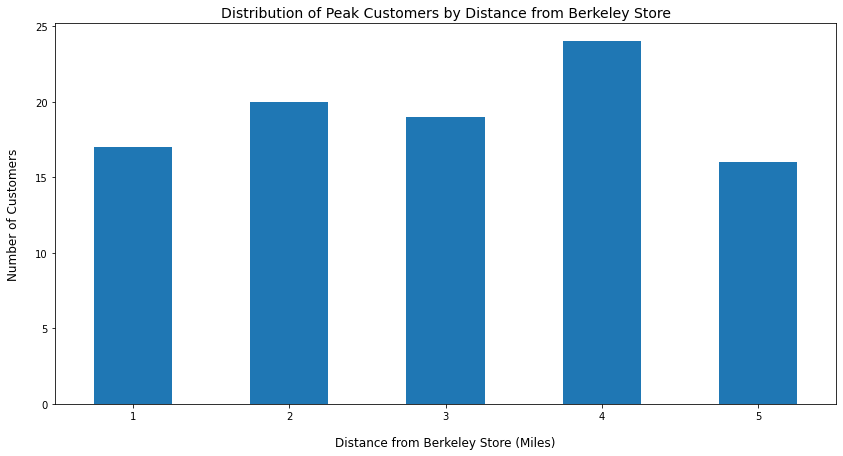

In [82]:
# Plot the results
fig, ax = plt.subplots()
final_df.groupby("distance")["total_customers"].sum().plot(kind="bar", figsize=(14,7))

# Add titles and axes labels
plt.title("Distribution of Peak Customers by Distance from Berkeley Store", fontsize=14)
ax.set_ylabel("Number of Customers", labelpad=15, fontsize=12)
ax.set_xlabel("Distance from Berkeley Store (Miles)", labelpad=15, fontsize=12)
plt.xticks(rotation=0);

# Summary

Since most AGM customers live within 15 miles of the closest store, we recommended considering a delivery service to capture customers who live farther away. We completed a proof of concept with Peak and validated that the relationship could work from a technical perspective. The above analysis, however, should give cause for hesitation in solidifying the relationship.

Ironically, the only customers who signed up for delivery service through Peak were those who live within 5 miles of the Berkeley store. This is not simply due to a relative concentration of addresses near the Berkeley store, as we validated that this distribution is similar to the national one.

Our recommendation is to pause forming a relationship with Peak. We think that additional analysis should be completed prior to entering into contract with them. More specifically, we should (1) determine how similar/different buying patterns are as distance from the closest store increases (perhaps those farther away just buy less frequently) and (2) discuss what Peak will commit to doing with respect to advertising AGM to customers located outside of a given radius of our store.